In [1]:
from train.training_session_v0 import load_training_session
import multiprocessing
import torch

device = "cuda"

session = load_training_session(
    save_path="saves/phase1/objectives/CLIP/epoch_16",
    studies={"gwilliams2023": "audio"},
    data_path="data",
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100)

recording = session.studies["gwilliams2023"].recordings[18][1][0]

print(
    f"Showing recording: {recording.study_name}_{recording.subject_id}_{recording.task_id}"
)

dataloader.start_fetching(recordings=[recording])
batch = dataloader.get_recording()
brain, audio, recording = (
    batch.brain_segments["all"].to(device),
    batch.audio_segments.to(device),
    batch.recording,
)

conditions = {
    "study": f"{recording.study_name}",
    "subject": f"{recording.study_name}_{recording.subject_id}",
}
session.model.to(device)

with torch.no_grad():
    pred, _ = session.model(
        x=[brain], recording=[recording], conditions=[conditions], train=False
    )

dataloader.stop()

Loading Gwilliams2023 with batch type audio
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 12, Unseen Subject: 45, Unseen Both: 4.

GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected.
SimpleConv initialized with 8448160 parameters, cond: ['study', 'subject']
Merger False, merger channels 0
ConvBlocks: 6, hidden_dim: 384, params 7973376


2024-12-24 19:01:51,637	INFO worker.py:1821 -- Started a local Ray instance.


Showing recording: Gwilliams2023_19_0


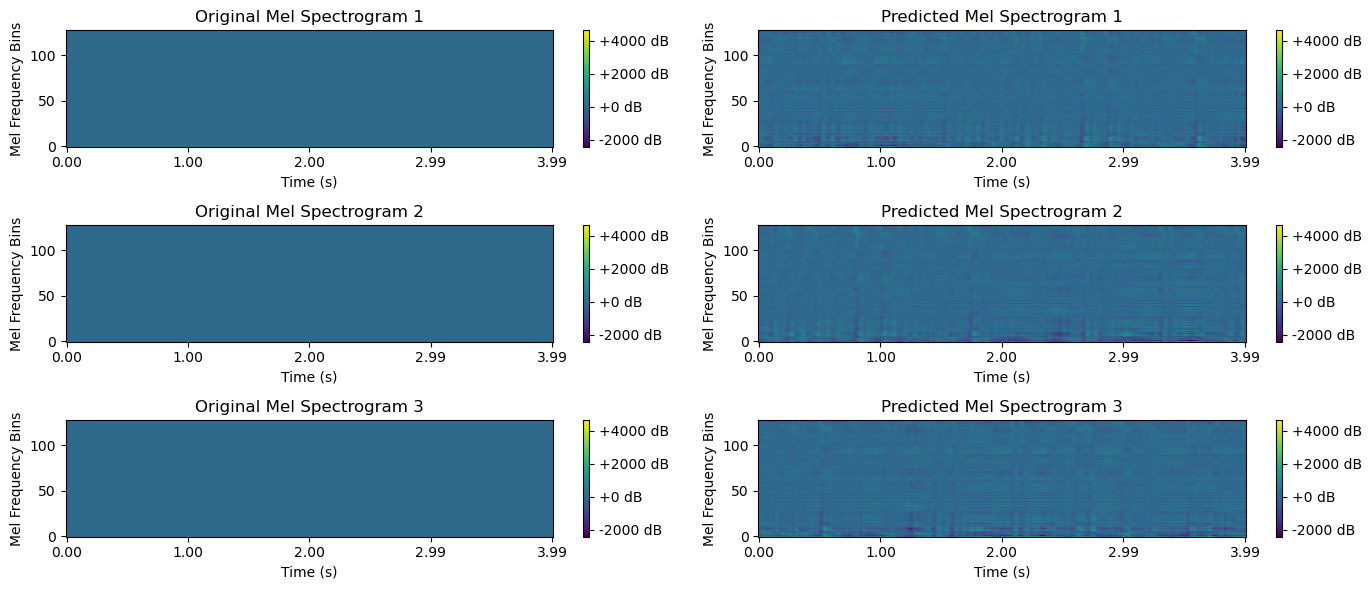

In [2]:
from utils.plot_mel import plot_mel_spectrogram

plot_mel_spectrogram(
    x=audio[15:18].cpu().numpy(),
    max_plots=3,
    x_pred=pred[15:18].cpu().numpy(),
)

In [3]:
audio.max(), audio.min(), audio.mean(), pred.max(), pred.min(), pred.mean()

(tensor(1.9235, device='cuda:0'),
 tensor(-0.2088, device='cuda:0'),
 tensor(0.4772, device='cuda:0'),
 tensor(6772.5972, device='cuda:0'),
 tensor(-3539.7803, device='cuda:0'),
 tensor(2.5441, device='cuda:0'))

In [4]:
# from utils.plot import plot_training_metrics
# plot_training_metrics(session.metrics)

: 